In [1]:
# %matplotlib widget

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import h5py
from struct import *
from PIL import Image

import open3d as o3d
import pyransac3d as pyrsc

from skspatial.objects import Plane
from skspatial.objects import Points
from skspatial.plotting import plot_3d

np.seterr(divide='ignore', invalid='ignore')

from pprint import pprint

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def get_bin_info(bin_file):
    with open(bin_file,'rb') as f:
        float_size = 4
        cor = f.read(float_size*3)
        cors = unpack('fff',cor) # origin in world coordinates
        cam = f.read(float_size*16)
        cams = unpack('ffffffffffffffff', cam) # camera pose
        f.close()
    return cors, cams

def read_mat(mat_file, return_as_flat=False, return_as_float=False):
    with h5py.File(mat_file, 'r') as f:
        data = f['depth_mat']
        amodal_list = []
        for i in data:
            depth = np.transpose(i, (1,0))
            depth = np.ceil(depth*1000).astype(np.uint16)

            if return_as_flat == True:
                depth = np.reshape(depth, (-1,))
            if return_as_float == True:
                depth = depth.astype(np.float32)/1000

            amodal_list.append(depth)
        f.close()
    amodal_list = np.array(amodal_list)
    return amodal_list

def read_bitshift(depth_path, return_as_flat=False, return_as_float=False):
    depth = cv2.imread(depth_path, -1)
    lower_depth = depth >> 3
    higher_depth = (depth % 8) << 13
    real_depth = (lower_depth | higher_depth)

    if return_as_flat:
        real_depth = np.reshape(real_depth, (-1,))
    if return_as_float:
        real_depth = real_depth.astype(np.float32)/1000
    return real_depth

def calculate_mapping_vectorize(bin_file, depth_img, return_as='2D', mapping_as='voxel'):
    # parameters
    img_height, img_width = (480, 640)
    img_scale = 1.0
    vox_unit = 0.02
    vox_size = (240,144,240)
    cam_K = np.array([518.8579 / img_scale, 0., img_width / (2 * img_scale),
                      0., 518.8579 / img_scale, img_height / (2 * img_scale),
                      0., 0., 1.], dtype=np.float32)
    # cam_K = np.array([518.8579, 0, 325.58,
    #                   0, 519.4696, 253.74,
    #                   0, 0, 1], dtype=np.float32)
    
    vox_origin, cam_pose = get_bin_info(bin_file)

    depth_mapping = np.ones_like(depth_img, dtype=np.int32) * -1
    mask = np.zeros_like(depth_img, dtype=np.bool_)

    img_y = np.repeat(np.expand_dims(np.arange(depth_img.shape[0]), axis=1), depth_img.shape[1], axis=1)
    img_x = np.repeat(np.expand_dims(np.arange(depth_img.shape[1]), axis=0), depth_img.shape[0], axis=0)

    point_cam_x = (img_x - cam_K[2]) * depth_img / cam_K[0]
    point_cam_y = (img_y - cam_K[5]) * depth_img / cam_K[4]
    point_cam_z = depth_img

    point_base_x = cam_pose[0 * 4 + 0] * point_cam_x + cam_pose[0 * 4 + 1] * point_cam_y + cam_pose[0 * 4 + 2] * point_cam_z;
    point_base_y = cam_pose[1 * 4 + 0] * point_cam_x + cam_pose[1 * 4 + 1] * point_cam_y + cam_pose[1 * 4 + 2] * point_cam_z;
    point_base_z = cam_pose[2 * 4 + 0] * point_cam_x + cam_pose[2 * 4 + 1] * point_cam_y + cam_pose[2 * 4 + 2] * point_cam_z;

    point_base_x = point_base_x + cam_pose[0 * 4 + 3];
    point_base_y = point_base_y + cam_pose[1 * 4 + 3];
    point_base_z = point_base_z + cam_pose[2 * 4 + 3];
    
    if mapping_as == 'pcd':
        z = (point_base_x - vox_origin[0]) / vox_unit
        x = (point_base_y - vox_origin[1]) / vox_unit
        y = (point_base_z - vox_origin[2]) / vox_unit
        
    elif mapping_as == 'voxel':
        z = np.floor((point_base_x - vox_origin[0]) / vox_unit)
        x = np.floor((point_base_y - vox_origin[1]) / vox_unit)
        y = np.floor((point_base_z - vox_origin[2]) / vox_unit)

        z = z.astype(np.int32)
        x = x.astype(np.int32)
        y = y.astype(np.int32)

    for i in range((480*640)):
        pix_x, pix_y = i // 640, i % 640

        if x[pix_x,pix_y] >= 0 and x[pix_x,pix_y] < vox_size[0] \
            and y[pix_x,pix_y] >= 0 and y[pix_x,pix_y] < vox_size[1] \
            and z[pix_x,pix_y] >= 0 and z[pix_x,pix_y] < vox_size[2]:

            vox_idx = z[pix_x,pix_y] * vox_size[0] * vox_size[1] \
                    + y[pix_x,pix_y] * vox_size[0] \
                    + x[pix_x,pix_y]
            
            depth_mapping[pix_x,pix_y] = vox_idx
            mask[pix_x,pix_y] = 1
            
    if return_as == '1D':
        return np.reshape(depth_mapping, (-1,))
    
    elif return_as == '2D':
        return depth_mapping

    elif return_as == '3D': # 3-channel XYZ
        mask = np.expand_dims(mask, axis=0)
        zxy = np.stack((z,x,y), axis=0)
        zxy = zxy * mask
        return zxy, mask
    
def details_and_fov(img_height, img_width, img_scale, vox_scale):
    vox_details = np.array([0.02 * vox_scale, 0.24], np.float32)
    camera_fov = np.array([518.8579 / img_scale, 0., img_width / (2 * img_scale),
                           0., 518.8579 / img_scale, img_height / (2 * img_scale),
                           0., 0., 1.], dtype=np.float32)
    return vox_details, camera_fov


def _diff_vec(img, axis=0):
    img_diff = np.diff(img, 1, axis)
    img_diff_l = img_diff[1:, :] if axis == 0 else img_diff[:, 1:]
    img_diff_h = img_diff[:-1, :] if axis == 0 else img_diff[:, :-1]
    img_diff = img_diff_l + img_diff_h
    pad_tuple = ((1, 1), (0, 0), (0, 0)) if axis == 0 else ((0, 0), (1, 1), (0, 0))
    padded = np.lib.pad(img_diff, pad_tuple, 'edge')
    return padded


def _gen_normal(depth_path):
    depth = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)
    lower_depth = depth >> 3
    higher_depth = (depth % 8) << 13
    real_depth = (lower_depth | higher_depth).astype(np.float32) / 1000
    _, fov = details_and_fov(*real_depth.shape, 1, 1)

    img_x = np.repeat(np.expand_dims(np.arange(real_depth.shape[0]), axis=1), real_depth.shape[1], axis=1)
    img_y = np.repeat(np.expand_dims(np.arange(real_depth.shape[1]), axis=0), real_depth.shape[0], axis=0)
    point_cam_x = (img_x - fov[2]) * real_depth / fov[0]
    point_cam_y = (img_y - fov[5]) * real_depth / fov[4]
    points = np.stack([point_cam_x, point_cam_y, real_depth], axis=2)

    diff_y = _diff_vec(points, axis=0)
    diff_x = _diff_vec(points, axis=1)
    normal = np.cross(diff_x, diff_y)
    normal_factor = np.expand_dims(np.linalg.norm(normal, axis=2), axis=-1)
    normal = np.where((normal_factor == 0.) | np.isnan(normal_factor), (0, 0, 0), normal / normal_factor)
    normal = (np.clip((normal + 1) / 2, 0, 1) * 65535).astype(np.uint16)

    return normal

In [3]:
filename, idx = 'NYU%04d_0000', 3

base_path  = r'C:\Users\Mama\Documents\research'.replace('\\','/')
img_path   = os.path.join(base_path, 'NYUCAD_render/NYUCADtrain_render', filename % idx + '_instance.png')
mat_path   = os.path.join(base_path, 'NYUCADtrain_amodal_depth', filename % idx + '_amodal_depths.mat')
depth_path = os.path.join(base_path, filename % idx + '_depth.png')
bin_path   = os.path.join(base_path, filename % idx + '.bin')

instance   = cv2.imread(img_path, -1)
# plt.imshow(instance); plt.show()

depth = read_bitshift(depth_path, return_as_float=True)
min_depth, max_depth = np.min(depth), np.max(depth)
print(min_depth, max_depth)

# mapping, _ = calculate_mapping_vectorize(bin_path, depth, return_as='3D', mapping_as='pcd')
# mapping = np.transpose(mapping, (1,2,0)).reshape((-1,3))

# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(mapping)
# points = np.asarray(pcd.points)
# print(pcd)

# plane = pyrsc.Plane()
# best_eq, best_inliers = plane.fit(points, 0.01)

# plane = pcd.select_by_index(best_inliers).paint_uniform_color([1, 0, 0])
# obb = plane.get_oriented_bounding_box()
# obb2 = plane.get_axis_aligned_bounding_box()
# obb.color = [0, 0, 1]
# obb2.color = [0, 1, 0]
# not_plane = pcd.select_by_index(best_inliers, invert=True)

# o3d.visualization.draw_geometries([not_plane, plane, obb, obb2])

# for i in np.unique(instance)[1:]:
#     mask = instance == i
#     plt_depth = depth * mask
#     plt_depth[0,0], plt_depth[0,1] = min_depth, max_depth # accommodate for matplotlib's scaling
#     plt.imshow(plt_depth, cmap='jet'); plt.show()

# mat = read_mat(mat_path)
    
# for m in mat:
#     m[0,0], m[0,1] = min_depth, max_depth # accommodate for matplotlib's scaling
#     plt.imshow(m, cmap='jet'); plt.show()

0.0 3.497


In [66]:
def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
#     o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])
#                                       zoom=0.3412,
#                                       front=[0.4257, -0.2125, -0.8795],
#                                       lookat=[2.6172, 2.0475, 1.532],
#                                       up=[-0.0694, -0.9768, 0.2024])

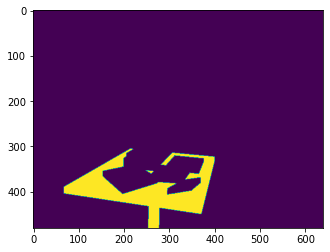

(1, 12453, 3)
[array([[118.42117709,  41.37111521,  43.63192262],
       [118.59880809,  41.41220652,  43.63789977],
       [118.75608994,  41.49865587,  43.6308917 ],
       ...,
       [152.13021316,   2.93986452,  43.54636256],
       [152.22423654,   2.96161491,  43.54952638],
       [152.30832944,   3.0779506 ,  43.50344751]]), array([[118.52943844,   2.90372864,  43.43948905],
       [118.67090031,   2.88747274,  43.46468503],
       [118.77862371,   2.91239235,  43.46830985],
       ...,
       [152.10940903,   2.92339908,  41.90736595],
       [152.20886779,   2.89816669,  41.93669898],
       [152.30317268,   2.9199822 ,  41.93987227]])]
(2,)


ValueError: cannot reshape array of size 2 into shape (3)

In [125]:
mask_idx = 5
mask = (instance == mask_idx).astype(np.uint8)
plt.imshow(mask); plt.show()

ins_depth = mask * depth
# plt.imshow(ins_depth, cmap='jet'); plt.show()

# Calculate point cloud
ins_mapping, mapping_mask = calculate_mapping_vectorize(bin_path, ins_depth, return_as='3D', mapping_as='pcd')
ins_mapping = ins_mapping[ins_mapping > 0].reshape((3,-1))
ins_mapping = np.transpose(ins_mapping, (1,0))

# Load point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(ins_mapping)

plane_list = []

# Get first plane
points = np.asarray(pcd.points)
plane = pyrsc.Plane()
_, best_inliers = plane.fit(points, 0.04) # plane eqn, indices for inlier pts
plane = pcd.select_by_index(best_inliers).paint_uniform_color([1, 0, 0]) # rough estimate of plane
_, ind = plane.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0) # refined estimate of plane

inlier_cloud = plane.select_by_index(ind) # inliers of plane
outlier_cloud = plane.select_by_index(ind, invert=True) # outliers of plane

inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
outlier_cloud.paint_uniform_color([1, 0, 0])

other_points = pcd.select_by_index(best_inliers, invert=True) # points other than the plane

# o3d.visualization.draw_geometries([other_points, inlier_cloud, outlier_cloud])

plane_list.append(np.asarray(plane.points)) # store plane
print(np.asarray(plane_list).shape)

# Check if there are other planes
while not other_points.is_empty():
    points = np.asarray(other_points.points)
    plane = pyrsc.Plane()
    _, best_inliers = plane.fit(points, 0.04)
    plane = other_points.select_by_index(best_inliers).paint_uniform_color([1, 0, 0]) # rough estimate of plane
    _, ind = plane.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0) # refined estimate of plane

    inlier_cloud = plane.select_by_index(ind)
    outlier_cloud = plane.select_by_index(ind, invert=True)

    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    outlier_cloud.paint_uniform_color([1, 0, 0])

    other_points = other_points.select_by_index(best_inliers, invert=True)
    
    plane_list_pcd = o3d.geometry.PointCloud()  
    plane_list_pcd.points = o3d.utility.Vector3dVector(np.asarray(plane_list).reshape(-1,3)) # because not same size
    
    o3d.visualization.draw_geometries([other_points, inlier_cloud, outlier_cloud, plane_list_pcd])

    plane_list.append(np.asarray(plane.points))
    print(plane_list)
    print(np.asarray(plane_list).shape)
asd

In [130]:
array_a = np.zeros((4,3))
array_b = np.ones((8,3))

_list = []
_list.append(array_a)
print(_list)

_list.append(array_b)
print(_list)

print(np.asarray(_list))

array = np.concatenate((p1_load,p2_load), axis=0)


[array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])]
[array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]]), array([[1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.]])]


ValueError: could not broadcast input array from shape (8,4) into shape (8,)

In [ ]:
plane_count = 0
while True:
    if plane_count == 0:
        points = np.asarray(pcd.points)
        plane = pyrsc.Plane()
        best_eq, best_inliers = plane.fit(points, 0.02)
        print(best_eq)
        plane = pcd.select_by_index(best_inliers).paint_uniform_color([1, 0, 0])
        
        plane, ind = plane.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
        
        inlier_cloud = plane.select_by_index(ind)
        outlier_cloud = plane.select_by_index(ind, invert=True)
        
        o3d.visualization.draw_geometries([outlier_cloud])

        # display_inlier_outlier(cl, ind)
        asd
        
        plane_count += 1
        
    else:
        points = np.asarray(not_plane.points)
        plane = pyrsc.Plane()
        best_eq, best_inliers = plane.fit(points, 0.02)
        plane = not_plane.select_by_index(best_inliers).paint_uniform_color([1, 0, 0])
        not_plane = not_plane.select_by_index(best_inliers, invert=True)
        
        cl, ind = plane.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
        display_inlier_outlier(plane, ind)
        
        plane_count += 1
    
    o3d.visualization.draw_geometries([not_plane, plane])
    
    inspect = np.asarray(plane.points)
    print(np.shape(inspect))
    
    if not_plane.is_empty():
        break
        
print("No of planes found:", plane_count)        
print(asd)

# obb = plane.get_oriented_bounding_box()
# obb2 = plane.get_axis_aligned_bounding_box()
# obb.color = [0, 0, 1]
# obb2.color = [0, 1, 0]
# o3d.visualization.draw_geometries([not_plane, plane, obb, obb2])
# o3d.visualization.draw_geometries([not_plane])
    

# points = np.asarray(not_plane.points)
# plane = pyrsc.Plane()
# best_eq, best_inliers = plane.fit(points, 0.03)
# plane = not_plane.select_by_index(best_inliers).paint_uniform_color([1, 0, 0])
# print(plane)
# not_plane = not_plane.select_by_index(best_inliers, invert=True)
# o3d.visualization.draw_geometries([not_plane])


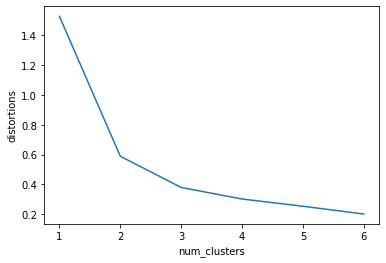

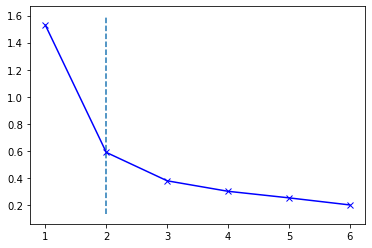

In [32]:
# normal = _gen_normal(depth_path)
# normal = normal.astype(np.float32) / normal.max()
# normal = (normal * 255).astype(np.uint8)

# ins_normal = np.expand_dims(mask, axis=-1) * normal
# ins_normal = ins_normal.astype(np.float32) / 255
# plt.imshow(ins_normal); plt.show()

import pandas as pd
import seaborn as sns
from scipy.cluster.vq import whiten
from scipy.cluster.vq import kmeans

# Collect features
r, g, b = [], [], []
valid_x, valid_y = np.where(mask != 0)
for idx in range(len(valid_x)):
    val = ins_normal[valid_x[idx], valid_y[idx]]
  
    r.append(val[0]); g.append(val[1]); b.append(val[2])

# Saving as DataFrame
normal_df = pd.DataFrame({'red' : r,
                          'green' : g,
                          'blue' : b})
 
# Scaling the values
normal_df['scaled_color_red'] = whiten(normal_df['red'])
normal_df['scaled_color_blue'] = whiten(normal_df['blue'])
normal_df['scaled_color_green'] = whiten(normal_df['green'])

# Preparing data to construct elbow plot.
distortions = []
num_clusters = range(1, 7)  # range of cluster sizes
 
# Create a list of distortions from the kmeans function
for i in num_clusters:
    cluster_centers, distortion = kmeans(normal_df[['scaled_color_red',
                                                    'scaled_color_blue',
                                                    'scaled_color_green']], i)
    distortions.append(distortion)
     
# Create a data frame with two lists, num_clusters and distortions
elbow_plot = pd.DataFrame({'num_clusters' : num_clusters,
                           'distortions' : distortions})
 
# Create a line plot of num_clusters and distortions
sns.lineplot(x = 'num_clusters', y = 'distortions', data = elbow_plot)
plt.xticks(num_clusters)
plt.show()

from kneed import KneeLocator
kn = KneeLocator(num_clusters, distortions, curve='convex', direction='decreasing')
plt.plot(num_clusters, distortions, 'bx-')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')


(<Figure size 720x720 with 1 Axes>, <Axes3DSubplot:xlabel='x', ylabel='y'>)

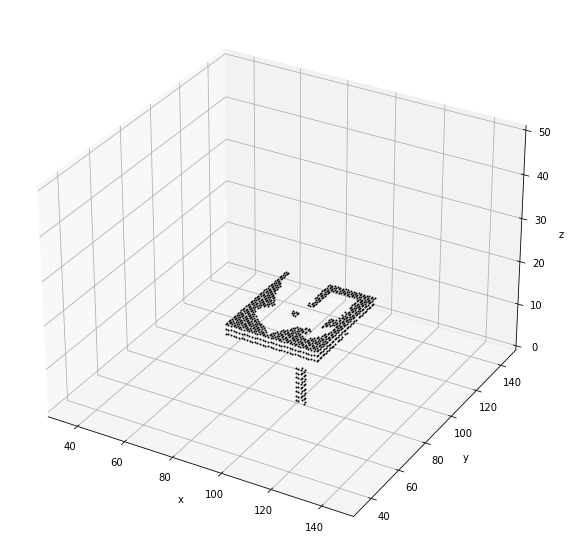

In [35]:
mapping, mask = calculate_mapping_vectorize(bin_path, ins_depth, return_as='3D')
mapping, mask = mapping.transpose((1,2,0)).reshape((-1,3)), mask.reshape(-1)

vox_in_scene_idx = np.where(mask != 0)
mapping = mapping[vox_in_scene_idx]

unique_vox = []
for i in range(len(mapping)):
    a,b,c = mapping[i,0], mapping[i,1], mapping[i,2]
    abc = (a << 8*2) + (b << 8*1) + (c << 8*0)
    
    if abc not in unique_vox:
        unique_vox.append(abc)
        
plot_points = np.zeros((len(unique_vox),3), dtype=np.int32)
for idx, abc in enumerate(unique_vox):
    a = abc >> 8*2
    b = (abc - (a << 8*2)) >> 8*1
    c = (abc - (a << 8*2) - (b << 8*1))
    
    plot_points[idx,0], plot_points[idx,1], plot_points[idx,2] = a,b,c
    
# 3D Plot
points = Points(plot_points)
# plane = Plane.best_fit(points)

# plot_3d(
#     points.plotter(c='k', s=1, depthshade=True),
#     plane.plotter(alpha=0.2, lims_x=(-50, 50), lims_y=(-50, 50)),
#     set_label=True
# )

# print(plane)

plot_3d(
    points.plotter(c='k', s=1, depthshade=False),
    figsize=(10,10),
    xlim3d=(30, 150), ylim3d=(30,150), zlim3d=(0,50),
    show_axis=True
)